In [180]:
import pandas as pd, os, os.path as op, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
sns.set()




####### SET DPI HERE #######
DPI = 600 ##################
############################




u = lambda x: list(set(x))

#make necessary folders
if not op.exists('plots'):
    os.mkdir('plots')
    


In [101]:
q = pd.read_excel(op.join('data',"quest.xlsx"))
c = pd.read_excel(op.join('data',"cogn.xlsx"))
p = pd.read_excel(op.join('data',"posner.xlsx"))
q = q.rename({'Participant Private ID':'id','Grupa':'group','Czy uzywa klawiatury i myszy zewnętrznej do gry lub pracy?':'keymouseuse',
         'Wiek':'age','Płec':'sex','Stan cywilny':'marital','Najwyższy ukonczony stopień edukacji':'edu',
          'Liczba ukończonych lat edukacji':'eduyears','Wielkość miasta zamieszkania':'size','Częstotliwość gry lub pracy':'pwfreq',
         'Ile pełnych lat gra lub pracuje':'pwyears','Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach':'pwhrsdaily3mo',
         'Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach':'pwhrsweekly3mo',
          'Czy kiedykolwiek czerpał korzyści materialne z grania w gry komputerowe?':'gainsever',
          'Czy obecnie utrzymuje się z grania w gry komputerowe?':'upkeepgamesnow',
         'Czy planuje kiedyś utrzymywać się z grania w gry komputerowe?':'upkeepgamesfuture'}, axis = 1)

c = c.rename({'Participant Private ID':'id','Zadanie':'task','Warunek':'condition',"Timed Out":'timeout'},axis=1)
c.columns = [col.lower() for col in c.columns]
p = p.rename({'Participant Private ID':'id','Zadanie':'task','Warunek':'condition',"Timed Out":'timeout',
             'Reaction Time':'rt'},axis=1)
p.columns = [col.lower() for col in p.columns]


q["group"] = q["group"].map({'Regularnie gram w League of Legends':"LoL",
                'Regularnie gram w Counter Strike: Global Offensive':"CS:GO",
                'Regularnie pracuję przy komputerze i nie gram w gry lub robię to rzadko (gry na konsole i smartfony nie są wliczane)':"Praca",
                'Regularnie pracuję lub uczę się przy komputerze i nie gram w gry lub robię to rzadko (gry na konsole i smartfony nie są wliczane)':"Praca"})

#drop columns with no variability
q = q.drop([col for col in q.columns if q[col].nunique() == 1],axis=1)


q['marital'] = q['marital'].map({'Kawaler/ panna':"Kawaler",'Żonaty/ zamężna':'Żonaty'})

#add group info to cognitive df
c["group"] = c['id'].map({pid:q[q['id'] == pid]['group'].values[0] for pid in q['id'].unique()})
p["group"] = p['id'].map({pid:q[q['id'] == pid]['group'].values[0] for pid in q['id'].unique()})
#change nans into zeros, drop trials with more attempts than possible
c['attempt'] = c['attempt'].replace({np.nan:0})
p['attempt'] = p['attempt'].replace({np.nan:0})
c = c[c['attempt'] <= 5]

c['trialtype'] = c['task'].apply(lambda x: x.split(":")[-1])
c['task'] = c['task'].apply(lambda x: x.split(":")[0])
c['task'] = c['task'].map({'Go/No-Go':'gonogo','Cued Task Switching':'cts','Posner Cueing Task':'posner','Visual Search Click on Location':'vsc'})

In [3]:
cDict = {}

for task in u([t.split(":")[0] for t in c['task'].unique()]):
    cDict[task] = c[c.task.str.contains(task)]
    
    if task == 'gonogo':
        cDict[task]['trialtype'] = cDict[task]['trialtype'].apply(lambda x: x.split()[0])
    else:
        cDict[task] = cDict[task].drop(['trialtype'],axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [126]:
d = p.copy()
d = d[(d['rt'] >= 100) & (d['rt'] <= 2000)]
d.loc[d["attempt"] == 0,'rt'] = np.nan
d = d.drop(['timeout','incorrect'], axis = 1)
d = d[~d.condition.isna()]
d['cue'] = d['cue'].apply(lambda x: x.split("Cue")[1].split('.')[0])
d['stimulus'] = d['stimulus'].apply(lambda x: x.split("Stimulus")[-1].split('.')[0])
d['congruent'] = (d['condition'] == d['cue']).map({True:"Congruent",False:"Incongruent"})

### Anova w schemacie mieszanym, sprawdzamy jak grupa i zgodność bodźca ze wskazówką różnicują czas reakcji

In [128]:
desc = d.groupby(['id','group','congruent']).agg(
    n = pd.NamedAgg(column='rt', aggfunc=np.size),
    rt_mean = pd.NamedAgg(column='rt', aggfunc=np.mean)
).reset_index()

In [133]:
pg.mixed_anova(data=desc,dv = 'rt_mean',within='congruent',between='group',subject='id').round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,287736.492,2,57,143868.246,10.843,0.000,0.276,NaN
1,congruent,134141.327,1,57,134141.327,255.527,0.000,0.818,1.0
2,Interaction,806.160,2,57,403.080,0.768,0.469,0.026,NaN


In [135]:
pg.pairwise_ttests(data=desc,dv = 'rt_mean',within='congruent',between='group',subject='id', parametric=True, marginal=True,
            alpha=0.05, tail='two-sided', padjust='sidak', effsize='hedges', correction='auto',
                nan_policy='listwise', return_desc=True, interaction=True, within_first=True).round(3)

,Contrast,congruent,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,congruent,-,Congruent,Incongruent,312.546,96.310,379.414,94.554,True,True,-16.048,59.0,two-sided,0.000,NaN,NaN,1.199e+20,-0.696
1,group,-,LoL,Praca,303.944,26.853,414.658,133.641,False,True,-3.632,38.0,two-sided,0.001,0.002,sidak,36.469,-1.126
2,group,-,LoL,CS:GO,303.944,26.853,319.338,36.349,False,True,-1.523,38.0,two-sided,0.136,0.355,sidak,0.767,-0.472
3,group,-,Praca,CS:GO,414.658,133.641,319.338,36.349,False,True,3.078,38.0,two-sided,0.004,0.012,sidak,10.455,0.954
4,congruent * group,Congruent,LoL,Praca,273.577,23.995,381.428,138.878,False,True,-3.422,38.0,two-sided,0.001,0.009,sidak,22.364,-1.061
5,congruent * group,Congruent,LoL,CS:GO,273.577,23.995,282.632,37.494,False,True,-0.910,38.0,two-sided,0.369,0.937,sidak,0.429,-0.282
6,congruent * group,Congruent,Praca,CS:GO,381.428,138.878,282.632,37.494,False,True,3.071,38.0,two-sided,0.004,0.023,sidak,10.313,0.952
7,congruent * group,Incongruent,LoL,Praca,334.311,34.988,447.887,131.664,False,True,-3.728,38.0,two-sided,0.001,0.004,sidak,45.88,-1.156
8,congruent * group,Incongruent,LoL,CS:GO,334.311,34.988,356.044,39.386,False,True,-1.845,38.0,two-sided,0.073,0.365,sidak,1.161,-0.572
9,congruent * group,Incongruent,Praca,CS:GO,447.887,131.664,356.044,39.386,False,True,2.989,38.0,two-sided,0.005,0.029,sidak,8.665,0.926


Jest efekt zgodności bodźcow - Szybsze są triale zgodne niż niezgodne (row 0)
Jest efekt grupy - LoL i CS:GO nie różnią się od siebie, obie grupy rozwiązują szybciej od Pracy (rows 1-3)

Nie ma efektu interakcji

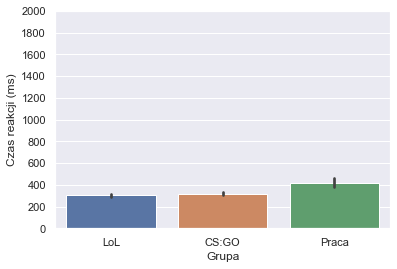

In [188]:
g = sns.barplot(data=desc,x='group',y='rt_mean',order=['LoL',"CS:GO","Praca"])
g.set(yticks=range(0,2001,200))
plt.xlabel("Grupa")
plt.ylabel("Czas reakcji (ms)")
#plt.show()
plt.savefig(op.join('plots','posner_group_rt_mean.png'),dpi = DPI)
plt.show()
plt.close()

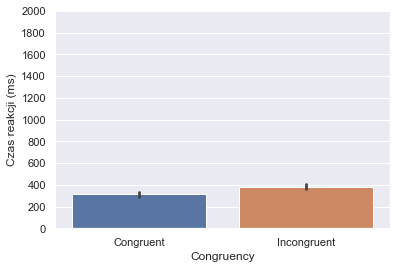

In [189]:
g = sns.barplot(data=desc,x='congruent',y='rt_mean',order=["Congruent","Incongruent"])
g.set(yticks=range(0,2001,200))
plt.xlabel("Congruency")
plt.ylabel("Czas reakcji (ms)")
plt.savefig(op.join('plots','posner_congruency_rt_mean.png'),dpi = DPI)
plt.show()
plt.close()

### Anova w schemacie mieszanym, sprawdzamy jak grupa i zgodność bodźca ze wskazówką różnicują poprawność odpowiedzi

In [146]:
correctness = d.groupby(['id','group','congruent']).agg(
    correct = pd.NamedAgg(column='correct', aggfunc=np.mean)
).reset_index()

In [148]:
pg.mixed_anova(data=correctness,dv = 'correct',within='congruent',between='group',subject='id').round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,0.013,2,57,0.006,5.635,0.006,0.165,NaN
1,congruent,0.060,1,57,0.060,137.099,0.000,0.706,1.0
2,Interaction,0.006,2,57,0.003,7.261,0.002,0.203,NaN


In [157]:
pg.pairwise_ttests(data=correctness,dv = 'correct',within='congruent',between='group',subject='id', parametric=True, marginal=True,
            alpha=0.05, tail='two-sided', padjust='sidak', effsize='hedges', correction='auto',
                nan_policy='listwise', return_desc=True, interaction=True, within_first=True).round(3)

,Contrast,congruent,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,congruent,-,Congruent,Incongruent,0.327,0.013,0.282,0.041,True,True,10.635,59.0,two-sided,0.000,NaN,NaN,2.769e+12,1.467
1,group,-,LoL,Praca,0.300,0.025,0.318,0.012,False,True,-2.850,38.0,two-sided,0.007,0.021,sidak,6.522,-0.883
2,group,-,LoL,CS:GO,0.300,0.025,0.294,0.030,False,True,0.760,38.0,two-sided,0.452,0.835,sidak,0.389,0.236
3,group,-,Praca,CS:GO,0.318,0.012,0.294,0.030,False,True,3.339,38.0,two-sided,0.002,0.006,sidak,18.525,1.035
4,congruent * group,Congruent,LoL,Praca,0.326,0.013,0.331,0.004,False,True,-1.640,38.0,two-sided,0.109,0.500,sidak,0.884,-0.508
5,congruent * group,Congruent,LoL,CS:GO,0.326,0.013,0.323,0.017,False,True,0.450,38.0,two-sided,0.655,0.998,sidak,0.335,0.140
6,congruent * group,Congruent,Praca,CS:GO,0.331,0.004,0.323,0.017,False,True,1.823,38.0,two-sided,0.076,0.378,sidak,1.127,0.565
7,congruent * group,Incongruent,LoL,Praca,0.275,0.039,0.306,0.024,False,True,-2.942,38.0,two-sided,0.006,0.033,sidak,7.873,-0.912
8,congruent * group,Incongruent,LoL,CS:GO,0.275,0.039,0.264,0.046,False,True,0.831,38.0,two-sided,0.411,0.958,sidak,0.406,0.257
9,congruent * group,Incongruent,Praca,CS:GO,0.306,0.024,0.264,0.046,False,True,3.602,38.0,two-sided,0.001,0.005,sidak,33.968,1.117


Jest efekt zgodności bodźcow - Poprawniej wykonywane triale zgodne niż niezgodne (row 0)
Jest efekt grupy - LoL i CS:GO nie różnią się od siebie, obie grupy rozwiązują mniej poprawnie od Pracy (rows 1-3)

Jest efekt interakcji!

W warunku congruent nie ma istotnych statystycznie różnic w poprawności odpowiedzi między grupami (rows 4-6)

W warunku incongruent LoL i CS:GO nie różnią się od siebie poprawnością odpowiedzi, pracujacy rozwiązują poprawniej od reszty

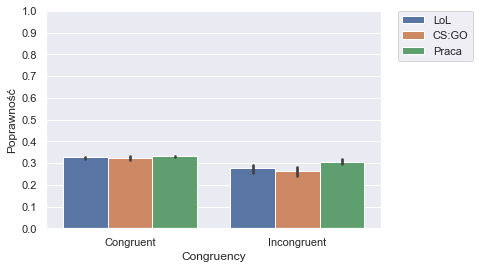

In [190]:
g = sns.barplot(data=correctness,x='congruent',y='correct',hue='group',order=["Congruent","Incongruent"],
               hue_order = ['LoL',"CS:GO","Praca"])
g.set(yticks=np.arange(0,1.1,.1))
plt.xlabel("Congruency")
plt.ylabel("Poprawność")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(op.join('plots','posner_group_congruency_correctness.png'),dpi = DPI)
plt.show()
plt.close()

In [161]:
q2 = q[['id','group','pwyears','pwhrsdaily3mo','pwhrsweekly3mo']]

#### Moderacje

Moderacja => zmienne kwestionariuszowe * grupa (gracze/niegracze) a czas reakcji

In [167]:
desc2 = d.groupby(['id','group']).agg(
    n = pd.NamedAgg(column='rt', aggfunc=np.size),
    rt_mean = pd.NamedAgg(column='rt', aggfunc=np.mean)
).reset_index()

In [168]:
mod1 = pd.merge(desc2, q2)
mod1['group'] = mod1['group'].map({"LoL":1,"CS:GO":1,"Praca":0})

for v in ["pwyears","pwhrsdaily3mo","pwhrsweekly3mo"]:
    mod1[f'group_{v}'] = mod1['group']*mod1[v]


### Ile pełnych lat gra lub pracuje

In [170]:
pg.linear_regression(X = mod1[['pwyears','group','group_pwyears']], y= mod1['rt_mean'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,439.865,37.683,11.673,0.000,0.292,0.254,364.378,515.353
1,pwyears,-12.028,8.773,-1.371,0.176,0.292,0.254,-29.602,5.546
2,group,-137.458,47.359,-2.902,0.005,0.292,0.254,-232.330,-42.586
3,group_pwyears,9.980,10.002,0.998,0.323,0.292,0.254,-10.055,30.016


Nie ma efektu lat - nie przekłada się do na zmianę czasu reakcji, jest efekt grupy (ale to już wiemy z poprzednich analiz)
Nie ma efektu interakcji, czyli nie ma moderacji

### Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach

In [171]:
pg.linear_regression(X = mod1[['pwhrsdaily3mo','group','group_pwhrsdaily3mo']], y= mod1['rt_mean'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,366.735,64.086,5.723,0.000,0.27,0.231,238.356,495.114
1,pwhrsdaily3mo,4.520,9.889,0.457,0.649,0.27,0.231,-15.289,24.330
2,group,-81.857,68.366,-1.197,0.236,0.27,0.231,-218.810,55.096
3,group_pwhrsdaily3mo,-3.353,10.487,-0.320,0.750,0.27,0.231,-24.361,17.656


W ogóle nic nie ma

### Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach

In [172]:
pg.linear_regression(X = mod1[['pwhrsweekly3mo','group','group_pwhrsweekly3mo']], y= mod1['rt_mean'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,407.796,61.124,6.672,0.000,0.268,0.229,285.350,530.241
1,pwhrsweekly3mo,-0.402,1.796,-0.224,0.824,0.268,0.229,-4.001,3.196
2,group,-122.559,65.849,-1.861,0.068,0.268,0.229,-254.470,9.352
3,group_pwhrsweekly3mo,0.584,1.893,0.309,0.759,0.268,0.229,-3.209,4.377


W ogóle nic nie ma

In [174]:
mod2 = d.groupby(['id','group']).agg(
    correct = pd.NamedAgg(column='correct', aggfunc=np.mean)).reset_index()

mod2 = pd.merge(mod2, q2)
mod2['group'] = mod2['group'].map({"LoL":1,"CS:GO":1,"Praca":0})

for v in ["pwyears","pwhrsdaily3mo","pwhrsweekly3mo"]:
    mod2[f'group_{v}'] = mod2['group']*mod2[v]

#### Moderacja => zmienne kwestionariuszowe * grupa (gracze/niegracze) a poprawność odpowiedzi

### Ile pełnych lat gra lub pracuje

In [176]:
pg.linear_regression(X = mod2[['pwyears','group','group_pwyears']], y= mod2['correct'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.325,0.008,42.482,0.000,0.111,0.064,0.310,0.341
1,pwyears,0.000,0.002,0.053,0.958,0.111,0.064,-0.003,0.004
2,group,-0.012,0.010,-1.286,0.204,0.111,0.064,-0.032,0.007
3,group_pwyears,0.000,0.002,0.011,0.991,0.111,0.064,-0.004,0.004


W ogóle nic nie ma

### Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach

In [178]:
pg.linear_regression(X = mod2[['pwhrsdaily3mo','group','group_pwhrsdaily3mo']], y= mod2['correct'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.325,0.012,27.066,0.000,0.223,0.181,0.301,0.349
1,pwhrsdaily3mo,0.000,0.002,0.082,0.935,0.223,0.181,-0.004,0.004
2,group,-0.001,0.013,-0.052,0.959,0.223,0.181,-0.026,0.025
3,group_pwhrsdaily3mo,-0.002,0.002,-1.020,0.312,0.223,0.181,-0.006,0.002


W ogóle nic nie ma

### Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach

In [179]:
pg.linear_regression(X = mod2[['pwhrsweekly3mo','group','group_pwhrsweekly3mo']], y= mod2['correct'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.326,0.012,26.813,0.000,0.117,0.07,0.302,0.351
1,pwhrsweekly3mo,-0.000,0.000,-0.070,0.944,0.117,0.07,-0.001,0.001
2,group,-0.010,0.013,-0.796,0.429,0.117,0.07,-0.037,0.016
3,group_pwhrsweekly3mo,-0.000,0.000,-0.124,0.902,0.117,0.07,-0.001,0.001


W ogóle nic nie ma